In [6]:
# ─── Cell 0: Imports ─────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from datetime import datetime
import time

# Headers required for stats.nba.com
HEADERS = {
    'Host': 'stats.nba.com',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US,en;q=0.5',
    'Referer': 'https://www.nba.com/',
    'Origin': 'https://www.nba.com',
    'Connection': 'keep-alive',
}

In [7]:
# ─── Cell 3: Team Class Definition ────────────────────────────────────────────────
class Team:
    def __init__(self, name, wins, games_played):
        self.name = name
        self.wins = wins
        self.games_played = games_played
        self.n = wins / games_played
        self.a1, self.b1, self.c1, self.d1, self.a2, self.b2, self.c2, self.d2 = generate_ordered_constants(self.n)

    def payoff_matrix(self):
        """
        Returns two 2×2 numpy arrays: (playoff_matrix, draft_matrix).
        """
        pm = np.array([[self.a1, self.b1],
                       [self.c1, self.d1]])
        dm = np.array([[self.a2, self.b2],
                       [self.c2, self.d2]])
        return pm, dm

    def expected_payoff(self):
        """
        Returns the 2×2 expected payoff matrix:
            M_exp = n * pm + (1 - n) * dm.
        """
        pm, dm = self.payoff_matrix()
        return self.n * pm + (1 - self.n) * dm
    
    def describe_matrix(self):
        """
        Creates  the expected payoff matrix 
          M_exp = n·M_playoff + (1−n)·M_draft,
        and then sums all entries to one float.
        """
        M_playoff, M_draft = self.payoff_matrix()
        M_exp = self.n * M_playoff + (1 - self.n) * M_draft
        scalar_payoff = M_exp.sum()  # sum over all four entries
        return scalar_payoff


In [8]:
def tank_GT(team: Team):
    n = team.n
    playoff_matrix, draft_matrix = team.payoff_matrix()

    # Expected payoff matrix as weighted average where each scalar is applied to its matrix and the results are summed 
    expected_matrix = n * playoff_matrix + (1 - n) * draft_matrix
    return expected_matrix

In [9]:
# ─── Cell 2: generate_ordered_constants ──────────────────────────────────────────
def generate_ordered_constants(n):
    """
    Generate (a1,b1,c1,d1, a2,b2,c2,d2) based on current win-rate n ∈ [0,1].
    a2–d2 scale with (1−n) for draft payoffs; a1–d1 offset from a2–d2 for playoff payoffs.
    """
    a2 = (1 - n) * 10 + np.random.uniform(0, 1)
    b2 = (1 - n) * 8  + np.random.uniform(0, 1)
    c2 = (1 - n) * 5  + np.random.uniform(0, 1)
    d2 = (1 - n) * 2  + np.random.uniform(0, 1)

    a1 = a2 + np.random.uniform(1, 2)
    b1 = b2 - np.random.uniform(1, 2)
    c1 = c2 + np.random.uniform(1, 2)
    d1 = c1 + np.random.uniform(1, 2)

    return a1, b1, c1, d1, a2, b2, c2, d2


In [10]:
for wins, gp in [(5, 20), (10, 20), (15, 20), (20, 20)]:
    t = Team("Testers", wins=wins, games_played=gp)
    print(f" Wins={wins}/{gp} (n={t.n:.3f})  →  Scalar Payoff = {t.describe_matrix():.3f}")

 Wins=5/20 (n=0.250)  →  Scalar Payoff = 21.118
 Wins=10/20 (n=0.500)  →  Scalar Payoff = 16.369
 Wins=15/20 (n=0.750)  →  Scalar Payoff = 11.781
 Wins=20/20 (n=1.000)  →  Scalar Payoff = 6.096


In [11]:
# ─── Cell 4: get_team_game_log ────────────────────────────────────────────────────
def get_team_game_log(team_id, season):
    """
    Fetch a team's regular‐season game log from stats.nba.com for "season" 
    (e.g. '2023-24'), returning a DataFrame sorted by date with columns:
      [GAME_DATE, WL, CUM_WINS, GAMES_PLAYED].
    Parses GAME_DATE in format "%b %d, %Y" (e.g. "APR 15, 2023").
    """
    url = 'https://stats.nba.com/stats/teamgamelog'
    params = {
        'TeamID': team_id,
        'Season': season,
        'SeasonType': 'Regular Season'
    }
    resp = requests.get(url, headers=HEADERS, params=params, timeout=10)
    resp.raise_for_status()

    data = resp.json()['resultSets'][0]
    columns = data['headers']
    rows = data['rowSet']

    df = pd.DataFrame(rows, columns=columns)
    # Convert "APR 15, 2023" → datetime with explicit format
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'], format="%b %d, %Y")
    df = df.sort_values('GAME_DATE').reset_index(drop=True)

    # Compute cumulative wins and games played
    wins = 0
    cum_wins = []
    for idx, row in df.iterrows():
        if row['WL'] == 'W':
            wins += 1
        cum_wins.append(wins)
    df['CUM_WINS'] = cum_wins
    df['GAMES_PLAYED'] = df.index + 1

    return df


In [12]:
# ─── Cell 5: Define Single Season & Fetch Team IDs ───────────────────────────────
season = '2023-24'

standings_url = 'https://stats.nba.com/stats/leaguestandingsv3'
params = {
    'LeagueID': '00',
    'Season': season,
    'SeasonType': 'Regular Season'
}
resp = requests.get(standings_url, headers=HEADERS, params=params)
resp.raise_for_status()

data = resp.json()['resultSets'][0]
columns = data['headers']
rows = data['rowSet']
df_standings = pd.DataFrame(rows, columns=columns)

# Correct column names are 'TeamID' and 'TeamName'
teams_info = [
    (int(row['TeamID']), row['TeamName'])
    for _, row in df_standings.iterrows()
]


In [13]:
# ─── Cell 6: Build team_logs for the Single Season ───────────────────────────────
team_logs = {}
missing = []  # to record any team_ids that fail permanently

DELAY_BETWEEN_REQUESTS = 0.7  # seconds between API calls
MAX_RETRIES_429 = 3          # maximum retries on HTTP 429

for team_id, team_name in teams_info:
    attempt = 0
    while True:
        attempt += 1
        try:
            df_log = get_team_game_log(team_id, season)
            team_logs[team_id] = (team_name, df_log)
            break  # success, exit retry loop

        except requests.exceptions.HTTPError as http_err:
            status = http_err.response.status_code
            if status == 429 and attempt <= MAX_RETRIES_429:
                backoff = 2 ** (attempt - 1)  # 1s, 2s, 4s
                print(f"⚠️  429 for {team_name} ({team_id}) in {season}; retrying in {backoff}s (attempt {attempt}/{MAX_RETRIES_429})")
                time.sleep(backoff)
                continue
            else:
                print(f"❗ HTTP error for {team_name} ({team_id}) in {season}: {http_err}")
                missing.append(team_id)
                break

        except requests.exceptions.Timeout:
            print(f"⏰ Timeout fetching {team_name} ({team_id}) for {season} on attempt {attempt}")
            missing.append(team_id)
            break

        except Exception as e:
            print(f"⚠️ Error fetching {team_name} ({team_id}) for {season}: {e}")
            missing.append(team_id)
            break

    time.sleep(DELAY_BETWEEN_REQUESTS)

print(f"\n✅ Finished building team_logs.  Successful entries: {len(team_logs)}")
if missing:
    print(f"⚠️ Failed to fetch {len(missing)} teams. Sample: {missing[:5]}")



✅ Finished building team_logs.  Successful entries: 30


In [14]:
# ─── Cell 7: Compute Scalar Payoff Series for All Teams (Single Season) ─────────
# Determine maximum number of games played by any team this season
max_games = max(len(df) for (_, df) in team_logs.values())

# Initialize DataFrame: index = 1..max_games, columns = team IDs
df_payoffs = pd.DataFrame(index=range(1, max_games + 1), columns=list(team_logs.keys()), dtype=float)

# Fill in each team’s scalar payoff at each game index
for team_id, (team_name, df_team) in team_logs.items():
    for idx, row in df_team.iterrows():
        t = idx + 1
        wins = row['CUM_WINS']
        gp = row['GAMES_PLAYED']
        team_obj = Team(team_name, wins=wins, games_played=gp)
        M_exp = team_obj.expected_payoff()
        scalar_payoff = M_exp.sum()  # sum of all four entries
        df_payoffs.at[t, team_id] = scalar_payoff
    # Remaining rows (if any) stay NaN


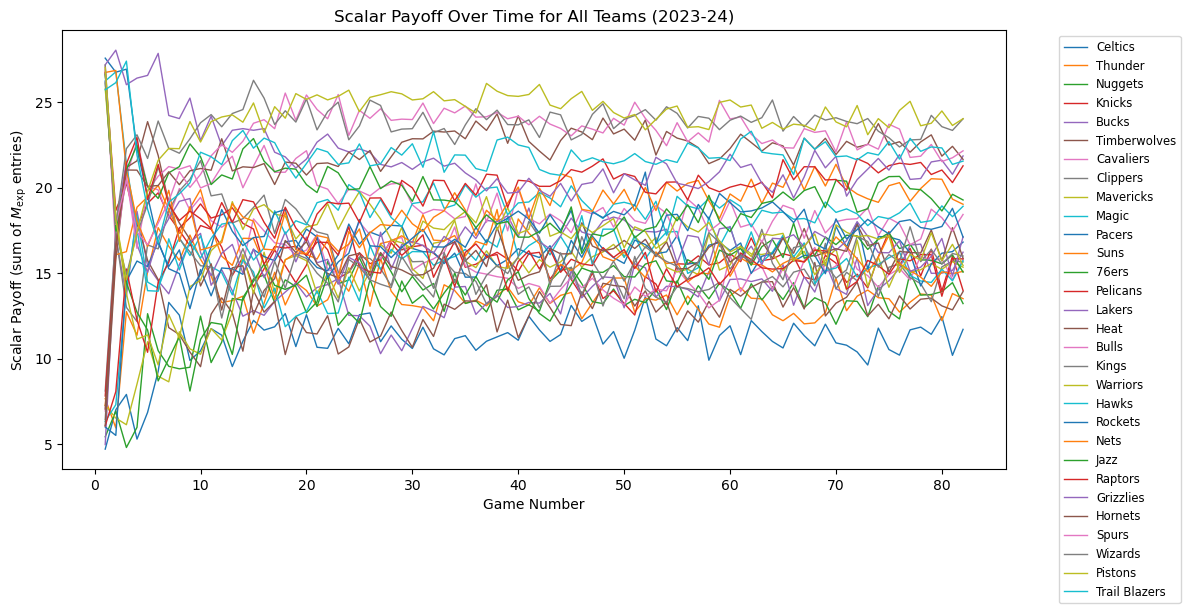

In [15]:
# ─── Cell 8: Plot Raw Scalar Payoff Curves for All Teams ─────────────────────────
plt.figure(figsize=(12, 6))
for team_id in df_payoffs.columns:
    team_name = team_logs[team_id][0]
    plt.plot(
        df_payoffs.index,
        df_payoffs[team_id].values,
        label=team_name,
        linewidth=1
    )

plt.title(f"Scalar Payoff Over Time for All Teams ({season})")
plt.xlabel("Game Number")
plt.ylabel("Scalar Payoff (sum of $M_{\\mathrm{{exp}}}$ entries)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


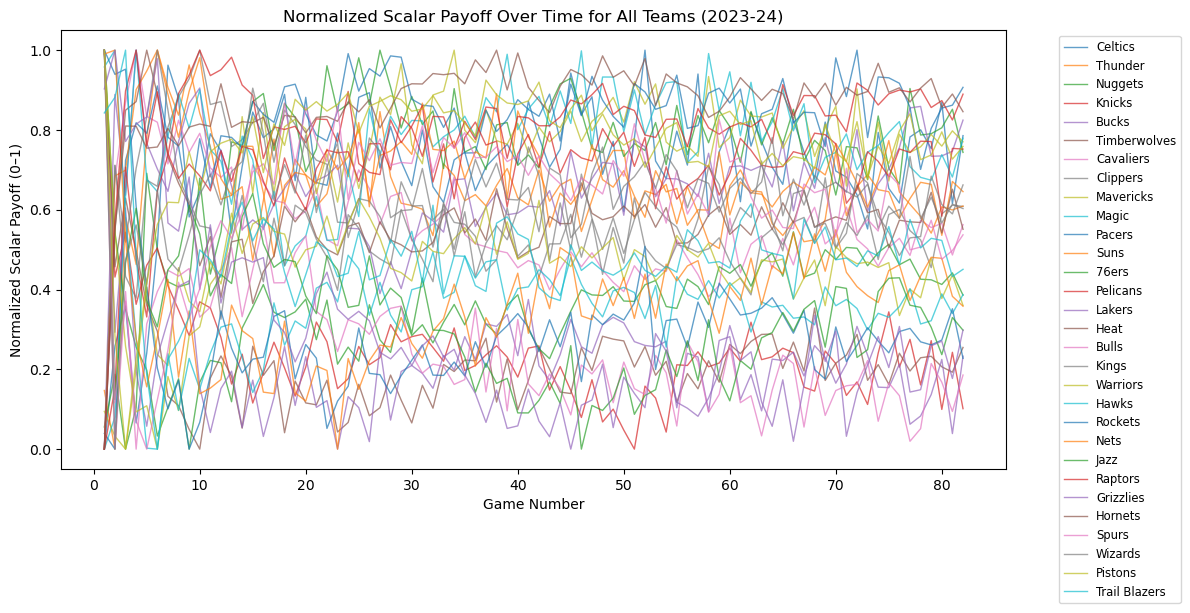

In [16]:
# ─── Cell 9: Normalize & Plot Normalized Scalar Payoff Curves ───────────────────
def normalize_columnwise(df):
    """
    Min–max normalize each column of df to [0,1].
    If a column has constant values (max == min), replace denom with 1 → column = 0.
    """
    col_min = df.min()
    col_max = df.max()
    denom = (col_max - col_min).replace(0, 1)
    return (df - col_min) / denom

df_payoffs_norm = normalize_columnwise(df_payoffs)

plt.figure(figsize=(12, 6))
for team_id in df_payoffs_norm.columns:
    team_name = team_logs[team_id][0]
    plt.plot(
        df_payoffs_norm.index,
        df_payoffs_norm[team_id].values,
        label=team_name,
        alpha=0.7,
        linewidth=1
    )

plt.title(f"Normalized Scalar Payoff Over Time for All Teams ({season})")
plt.xlabel("Game Number")
plt.ylabel("Normalized Scalar Payoff (0–1)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


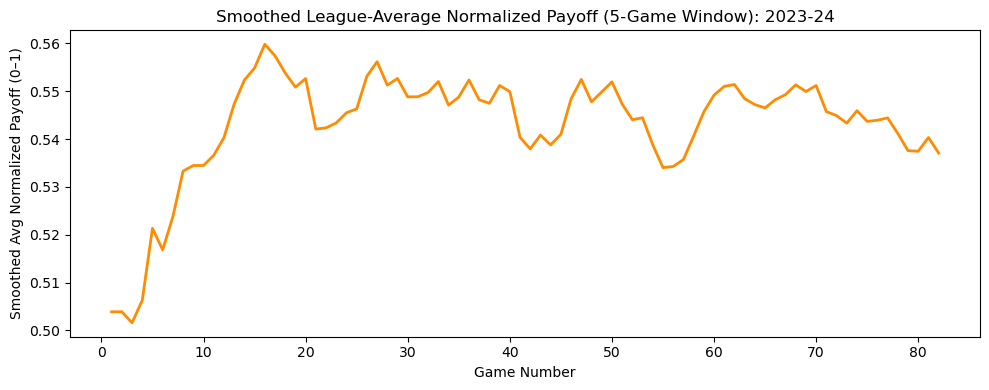

In [17]:
# ─── Cell 10: Plot League‐Average Smoothed Normalized Payoff ─────────────────────
# 1) Compute row‐wise mean (ignoring NaNs)
avg_norm_payoff = df_payoffs_norm.mean(axis=1)

# 2) Apply a 5‐game centered rolling mean
avg_norm_smoothed = avg_norm_payoff.rolling(window=5, min_periods=1, center=True).mean()

plt.figure(figsize=(10, 4))
plt.plot(
    avg_norm_smoothed.index,
    avg_norm_smoothed.values,
    color='darkorange',
    linewidth=2
)
plt.title(f"Smoothed League‐Average Normalized Payoff (5‐Game Window): {season}")
plt.xlabel("Game Number")
plt.ylabel("Smoothed Avg Normalized Payoff (0–1)")
plt.tight_layout()
plt.show()
